# CensoredNormal_Implementation

This notebook is protoype for developing and testing Pytorch and PYro compatible implementation of the censored normal distribution.

In [ ]:
!pip install -q pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 10.4 MB/s eta 0:00:00


In [ ]:
import os
from functools import partial

import torch
import torch.nn as nn
import torch.distributions.constraints as constraints

import numpy as np

import pyro
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
#assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


## Sampling From Normal Distribution

* likelihood estimation of the parameters of censored and truncated distribution to demonstrate the impact of the transformations on the underlying normal distribution

In [ ]:
def optimise_likelihood(x, num_iterations=1000):
    pyro.clear_param_store()
    loc_ = torch.tensor([0.], requires_grad=True)
    scale_ = torch.tensor([1.], requires_grad=True)
    optimizer = torch.optim.Adam([loc_, scale_], lr=0.05)

    pbar = tqdm(range(num_iterations), position=0, leave=True)

    losses = []
    for epoch in pbar:
        optimizer.zero_grad()
        pX = dist.Normal( loc_, scale_)
        loss = -pX.log_prob(x).mean()     # "forward" compute the loss (neg avg log-likelihood)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()                   # "backward" compute the gradient (& unfortunately clear stuff)
        losses.append(loss.item())
    res = {
        'loc': loc_.item(),
        'scale' : scale_.item()
        }
    return res

In [ ]:
N = 500
true_sigma = 5.0
true_loc = 13.


# generate the data
X = dist.Uniform(torch.tensor([-5.]), torch.tensor([35.0]))
Y = dist.Normal(torch.tensor([true_loc]), torch.tensor([true_sigma]))

x = X.sample(sample_shape=(N,))
y = Y.sample(sample_shape=(N,))

# censor the data
lower_bound = 3.
upper_bound = 16.

y_censored = torch.clamp(y, min=lower_bound, max=upper_bound)
mask = (y < lower_bound)  | (y > upper_bound)
y_censored_indices = torch.nonzero(mask, as_tuple=True)[0]
y_truncated_indices = torch.nonzero(~mask, as_tuple=True)[0]

x_truncated = x[y_truncated_indices]
y_truncated = y[y_truncated_indices]

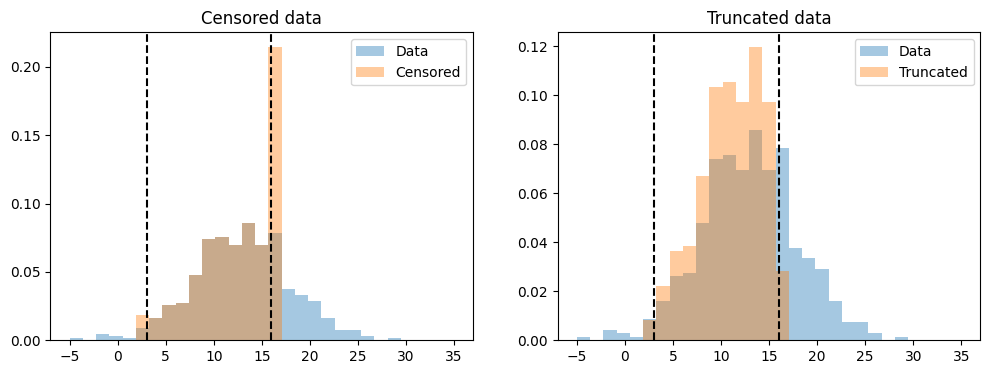

In [ ]:
# Visualize uncensored, censored and truncated data
_, ax = plt.subplots(1,2, figsize=(12, 4))
edges = np.linspace(-5, 35, 30)
for ax_ in ax:
  ax_.hist(y.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.4, label="Data")
  [ax_.axvline(x=x, c="k", ls="--") for x in [lower_bound, upper_bound]]

ax[0].hist(y_censored.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.4, label="Censored")
ax[0].legend()
_ = ax[0].set(title="Censored data")

ax[1].hist(y_truncated.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.4, label="Truncated")
ax[1].legend()
_ = ax[1].set(title="Truncated data")

#plt.savefig('dists.pdf', format='pdf')

In [ ]:
# parameters for non-censored data are: loc = 13., scale =5.
print(" all data")
print(optimise_likelihood(y, 10000))
print('sample mean: {: .5f}, sample std: {: .5f}'.format(y.mean().item(), y.std().item()))

 all data


  0%|          | 0/10000 [00:00<?, ?it/s]

{'loc': 13.006156005290995, 'scale': 5.096483645363328}
sample mean:  13.00616, sample std:  5.10159


In [ ]:
# parameters for non-censored data are: loc = 13., scale =5.
print("censored")
print(optimise_likelihood(y_censored, 10000))
print('sample mean: {: .5f}, sample std: {: .5f}'.format(y_censored.mean().item(), y_censored.std().item()))

censored


  0%|          | 0/10000 [00:00<?, ?it/s]

{'loc': 12.218376445648877, 'scale': 3.715105177834418}
sample mean:  12.21838, sample std:  3.71883


In [ ]:
# parameters for non-censored data are: loc = 13., scale =5.
print("truncated")
print(optimise_likelihood(y_truncated, 10000))
print('sample mean: {: .5f}, sample std: {: .5f}'.format(y_truncated.mean().item(), y_truncated.std().item()))

truncated


  0%|          | 0/10000 [00:00<?, ?it/s]

{'loc': 11.03133955973232, 'scale': 3.2266715811525906}
sample mean:  11.03134, sample std:  3.23120


## Implementing Censored Normal

In [159]:
import math
from numbers import Number, Real

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

from pyro.distributions.torch_distribution import TorchDistribution
from pyro.distributions.util import broadcast_shape

__all__ = ["CensoredNormal"]


class CensoredNormal(ExponentialFamily):
    """
    Creates a censored normal (also called Gaussian) distribution parameterized by
    :attr:`loc` and :attr:`scale` and :attr:`low`  and :attr:`high`

    Example::

        >>> # xdoctest: +IGNORE_WANT("non-deterministic")
        >>> m = CensoredNormal(
          torch.tensor([0.0]), torch.tensor([1.0]),
          torch.tensor([-0.5]), torch.tensor([0.5])
          )
        >>> m.sample(sample_shape=(3,1))
        tensor([[0.5000],
            [0.5000],
            [0.1836]])
        tensor([ 0.1046])

    Args:
        loc (float or Tensor): mean of the base normal distribution (often referred to as mu) to which the censoring is applied
        scale (float or Tensor): standard deviation of the base normal distribution to which the censoring is applied
        low (float or Tensor): lower censoring boundary
        high (float or Tensor): upper censoring boundary
    """
    arg_constraints = {
        "loc": constraints.real,
        "scale": constraints.positive,
        "low": constraints.dependent(is_discrete=False, event_dim=0),
        "high": constraints.dependent(is_discrete=False, event_dim=0)}
    has_rsample = True
    _mean_carrier_measure = 0

    @property
    def mean(self):
      x1 = (self.low - self.loc)/self.scale
      x2 = (self.high - self.loc)/self.scale
      term1 = math.exp(self._normal_log_prob(x2)) - math.exp(self._normal_log_prob(x1))
      term2 = self._normal_cdf(x2) - self._normal_cdf(x1)
      return self.loc * term1 - self.scale * term2

    @property
    def stddev(self):
        return self.variance.sqrt()

    @property
    def variance(self):
        x1 = (self.low - self.loc)/self.scale
        x2 = (self.high - self.loc)/self.scale
        term1 = x2 * math.exp(self._normal_log_prob(x2)) - x1 * math.exp(self._normal_log_prob(x1))
        term2 = self._normal_cdf(x2) - self._normal_cdf(x1)
        return  self.scale * (term1 - term2)


    def __init__(self, loc, scale, low, high, validate_args=None):
        self.loc, self.scale, self.low, self.high = broadcast_all(loc, scale, low, high)
        if isinstance(loc, Number) and isinstance(scale, Number) and isinstance(low, Number) and isinstance(high, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
        support = constraints.interval(low, high)
        super().__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(CensoredNormal, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        new.low = self.low.expand(batch_shape)
        new.high = self.high.expand(batch_shape)
        super(CensoredNormal, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    @constraints.dependent_property(is_discrete=False, event_dim=0)
    def support(self):
        return constraints.interval(self.low, self.high)


    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            samples = torch.normal(self.loc.expand(shape), self.scale.expand(shape))
            return samples.clamp(min=self.low, max=self.high)


    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        rsamples =  self.loc + eps * self.scale
        return rsamples.clamp(min=self.low, max=self.high)

    def pdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        probs = torch.exp(self.log_prob(value))
        lower_cdf_mass = self._normal_cdf(self.low)
        upper_cdf_mass = 1 - self._normal_cdf(self.high)
        probs = torch.where(value <= self.low, lower_cdf_mass, probs)
        probs = torch.where(value >= self.high, upper_cdf_mass, probs)
        return probs

    def log_prob(self, value, jitter=1e-12):
        """jitter: used to bounce off NormCDF from 0 before applying log """
        if self._validate_args:
            self._validate_sample(value)
        log_probs = self._normal_log_prob(value)
        lower_log_cdf_mass = math.log(self._normal_cdf(self.low) + jitter) if isinstance(self._normal_cdf(self.low) + jitter,
                                                                                                Number) else (self._normal_cdf(self.low) + jitter).log()
        upper_log_cdf_mass = math.log(1 - self._normal_cdf(self.high) + jitter) if isinstance(1 - self._normal_cdf(self.high) + jitter,
                                                                                                    Number) else (1 - self._normal_cdf(self.high) + jitter).log()
        log_probs = torch.where(value <= self.low, lower_log_cdf_mass, log_probs)
        log_probs = torch.where(value >= self.high, upper_log_cdf_mass, log_probs)
        return log_probs

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        cdf_ = self._normal_cdf(value)
        cdf_ = torch.where(value < self.low, 0, cdf_)
        cdf_ = torch.where(value > self.high, 1, cdf_)
        return cdf_

    def icdf(self, value):
        result = self._normal_icdf(value)
        return result.clamp(min=self.low, max=self.high)

    def entropy(self, jitter=1e-12):
        x_low = (self.low - self.loc)/self.scale
        x_high = (self.high - self.loc)/self.scale
        logcdf_x_low = math.log(self._normal_cdf(x_low) + jitter) if isinstance(self._normal_cdf(x_low) + jitter,
                                                                                                  Number) else (self._normal_cdf(x_low) + jitter).log()
        logcdf_x_high = math.log(1 - self._normal_cdf(x_high) + jitter) if isinstance(1 - self._normal_cdf(x_high) + jitter,
                                                                                                      Number) else (1 - self._normal_cdf(x_high) + jitter).log()

        term1 = self._normal_entropy() * (self._normal_cdf(x_high)- self._normal_cdf(x_low))
        term2 = 0.5 * (x_high * torch.exp(self._normal_log_prob(x_high)) - x_low * torch.exp(self._normal_log_prob(x_low)))
        term3 = logcdf_x_high * (1. - self._normal_cdf(x_high)) -  logcdf_x_low * self._normal_cdf(x_low)
        return term1 - term2 - term3


    def _normal_log_prob(self, value):
            # compute the variance
            var = self.scale**2
            log_scale = (
                math.log(self.scale) if isinstance(self.scale, Real) else self.scale.log()
            )
            return (
                -((value - self.loc) ** 2) / (2 * var)
                - log_scale
                - math.log(math.sqrt(2 * math.pi))
            )

    def _normal_cdf(self, value):
        return 0.5 * (
            1 + torch.erf((value - self.loc) * self.scale.reciprocal() / math.sqrt(2))
        )

    def _normal_icdf(self, value):
        return self.loc + self.scale * torch.erfinv(2 * value - 1) * math.sqrt(2)


    def _normal_entropy(self):
        return 0.5 + 0.5 * math.log(2 * math.pi) + torch.log(self.scale)

    @property
    def _normal_natural_params(self):
        return (self.loc / self.scale.pow(2), -0.5 * self.scale.pow(2).reciprocal())

    def _log_normalizer(self, x, y):
        return -0.25 * x.pow(2) / y + 0.5 * torch.log(-math.pi / y)


class PyroCensoredNormal(CensoredNormal, TorchDistribution):
    def __init__(self, loc, scale, low, high, validate_args=None, **kwargs):
        self._unbroadcasted_loc = loc
        self._unbroadcasted_scale = scale
        self._unbroadcasted_low = low
        self._unbroadcasted_high = high
        super().__init__(loc, scale, low, high, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(type(self), _instance)
        new = super().expand(batch_shape, _instance=new)
        new._unbroadcasted_loc = self._unbroadcasted_loc
        new._unbroadcasted_scale = self._unbroadcasted_scale
        new._unbroadcasted_low = self._unbroadcasted_low
        new._unbroadcasted_high = self._unbroadcasted_high
        return new

    @constraints.dependent_property(is_discrete=False, event_dim=0)
    def support(self):
        return constraints.interval(self._unbroadcasted_low, self._unbroadcasted_high)

In [160]:
m = CensoredNormal(
          torch.tensor([0.0]), torch.tensor([1.0]), torch.tensor([-0.5]), torch.tensor([0.5]))

data = m.sample(sample_shape=(10,))
data

tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [ 0.5000],
        [ 0.5000],
        [ 0.1309],
        [ 0.5000],
        [ 0.2569],
        [-0.3283],
        [ 0.5000]])

In [161]:
m.pdf(data), m.log_prob(data), m.cdf(data), m.icdf(m.cdf(data)), m.entropy(), m._normal_entropy(), m.mean, m.variance

(tensor([[0.3085],
         [0.3085],
         [0.3085],
         [0.3085],
         [0.3085],
         [0.3955],
         [0.3085],
         [0.3860],
         [0.3780],
         [0.3085]]),
 tensor([[-1.1759],
         [-1.1759],
         [-1.1759],
         [-1.1759],
         [-1.1759],
         [-0.9275],
         [-1.1759],
         [-0.9519],
         [-0.9728],
         [-1.1759]]),
 tensor([[0.3085],
         [0.6915],
         [0.6915],
         [0.6915],
         [0.6915],
         [0.5521],
         [0.6915],
         [0.6014],
         [0.3713],
         [0.6915]]),
 tensor([[-0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.5000],
         [ 0.1309],
         [ 0.5000],
         [ 0.2569],
         [-0.3283],
         [ 0.5000]]),
 tensor([0.3673]),
 tensor([1.4189]),
 tensor([-0.3829]),
 tensor([-0.0309]))

In [162]:
N = 500
true_sigma = 1.0
true_loc = .5

# censor the data
lower_bound = -0.5
upper_bound = 2.

torch.Generator().manual_seed(42)

# generate the data
X = dist.Uniform(torch.tensor([-7.]), torch.tensor([7]))

torch.manual_seed(42)
Y = dist.Normal(torch.Tensor([true_loc]), torch.Tensor([true_sigma]))

torch.manual_seed(42)
Z = CensoredNormal(torch.Tensor([true_loc]), torch.Tensor([true_sigma]),
                   torch.tensor([lower_bound]), high=torch.tensor([upper_bound]))

W = dist.HalfNormal(torch.tensor([true_sigma]))

x = X.sample(sample_shape=(N,))

torch.manual_seed(42)
y = Y.sample(sample_shape=(N,))

torch.manual_seed(42)
z = Z.sample(sample_shape=(N,))

torch.manual_seed(42)
w = W.sample(sample_shape=(N,))

y_censored = torch.clamp(y, min=lower_bound, max=upper_bound)
mask = (y < lower_bound)  | (y > upper_bound)
y_censored_indices = torch.nonzero(mask, as_tuple=True)[0]
y_truncated_indices = torch.nonzero(~mask, as_tuple=True)[0]

x_truncated = x[y_truncated_indices]
y_truncated = y[y_truncated_indices]

## moments and entropy sanity check

In [163]:
grid = torch.linspace(lower_bound,upper_bound, 20000)
h = torch.linspace(lower_bound,upper_bound, 20000).diff()[0]
sample = Z.sample(sample_shape=[10000])

In [ ]:
grid[1:-1], grid

(tensor([-0.4997, -0.4995, -0.4992,  ...,  1.9992,  1.9995,  1.9997]),
 tensor([-0.5000, -0.4997, -0.4995,  ...,  1.9995,  1.9997,  2.0000]))

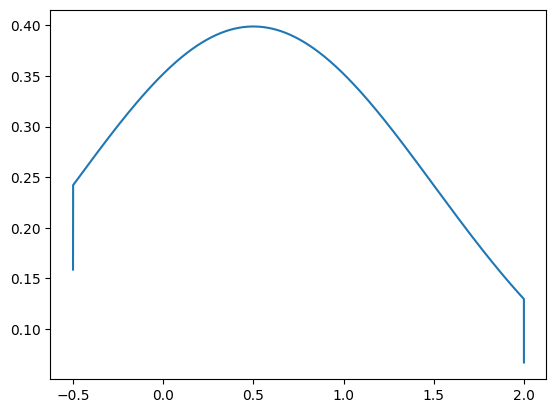

In [165]:
plt.plot(grid.numpy(), Z.pdf(grid).numpy())

### pdf and logpdf implementation

In [166]:
(Z.pdf(grid[1:-1])*h).sum(0) + Z._normal_cdf(lower_bound) + 1. - Z._normal_cdf(upper_bound), (Z.pdf(grid[1:-1])*h).sum(0) + Z.pdf(grid[0]).item() + Z.pdf(grid[-1]).item()

(tensor([1.0000]), tensor(1.0000))

In [167]:
(Z.pdf(grid)*h).sum(0)

tensor(0.7745)

In [ ]:
Z.pdf(grid), 1. - Z._normal_cdf(upper_bound), Z._normal_cdf(lower_bound)

(tensor([0.1587, 0.2420, 0.2421,  ..., 0.1296, 0.1296, 0.0668]),
 tensor([0.0668]),
 tensor([0.1587]))

In [ ]:
(Z.log_prob(grid[1:-1]).exp()*h).sum(0) + Z.log_prob(grid[0]).exp().item() + Z.log_prob(grid[-1]).exp().item()

tensor(1.0000)

In [ ]:
Z.log_prob(grid), (1. - Z._normal_cdf(upper_bound)).log(), Z._normal_cdf(lower_bound).log()

(tensor([-1.8410, -1.4187, -1.4184,  ..., -2.0432, -2.0436, -2.7059]),
 tensor([-2.7059]),
 tensor([-1.8410]))

In [168]:
(grid[1:-1] * Z.pdf(grid[1:-1])* h).sum(0) + grid[0] * Z.pdf(grid[0]) + grid[-1] * Z.pdf(grid[-1]), Z.mean

(tensor([0.5540]), tensor([-0.7183]))

In [169]:
(h * (Z.pdf(grid[1:-1])*(grid[1:-1]-Z.loc)**2)).sum(0) + Z.pdf(grid[0]).item()*(grid[0]-Z.loc).item()**2 + Z.pdf(grid[-1]).item()*(grid[-1] - Z.loc).item()**2, Z.variance

(tensor(0.6472), tensor([-0.2821]))

In [171]:
(-Z.pdf(grid)*Z.log_prob(grid)*h).sum(0), Z.entropy()

(tensor(0.8809), tensor([0.9641]))

In [170]:
-(Z.pdf(grid)*Z.log_prob(grid)*h).sum(0), -(Z.log_prob(grid).exp() *Z.log_prob(grid) * h).sum(0),

(tensor(0.8809), tensor(0.8809))

In [ ]:
torch.linspace(lower_bound,upper_bound,10000).diff()[0]

tensor(0.0003)

In [ ]:
(Z.pdf(torch.linspace(lower_bound,upper_bound,10000)) * torch.linspace(lower_bound,upper_bound,10000)).mean(0)

tensor(0.2094)

In [ ]:
Z.mean

-0.06344364101144456

## sampling sanity check

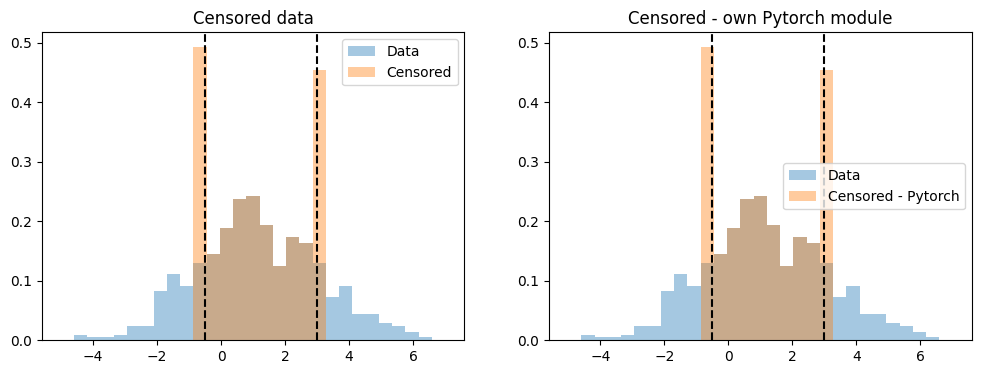

In [ ]:
# Visualize uncensored, censored and truncated data
_, ax = plt.subplots(1,2, figsize=(12, 4))
edges = np.linspace(-5, 7, 30)
for ax_ in ax:
  ax_.hist(y.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.4, label="Data")
  [ax_.axvline(x=x, c="k", ls="--") for x in [lower_bound, upper_bound]]

ax[0].hist(y_censored.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.4, label="Censored")
ax[0].legend()
_ = ax[0].set(title="Censored data")

ax[1].hist(z.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.4, label="Censored - Pytorch")
ax[1].legend()
_ = ax[1].set(title="Censored - own Pytorch module")


In [ ]:
def optimise_likelihood_censored(x, num_iterations=1000, loc_init_=0., scale_init_=1., low_=-0.5, high_=3.):
    pyro.clear_param_store()
    loc_ = torch.tensor([loc_init_], requires_grad=True)
    scale_ = torch.tensor([scale_init_], requires_grad=True)
    lower_ = torch.tensor([low_], requires_grad=False)
    upper_ = torch.tensor([high_], requires_grad=False)
    optimizer = torch.optim.Adam([loc_, scale_], lr=0.05)

    pbar = tqdm(range(num_iterations), position=0, leave=True)

    losses = []
    for epoch in pbar:
        optimizer.zero_grad()
        pX = CensoredNormal(loc_, scale_,lower_, upper_)
        loss = -pX.log_prob(x).mean()     # "forward" compute the loss (neg avg log-likelihood)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()                   # "backward" compute the gradient (& unfortunately clear stuff)
        losses.append(loss.item())
    res = {
        'loc': loc_.item(),
        'scale' : scale_.item()
        }
    return res

In [ ]:
print("optimised with censored likelihood")
print(optimise_likelihood_censored(z, 10000))
print('sample mean: {: .5f}, sample std: {: .5f}'.format(z.mean().item(), z.std().item()))

optimised with censored likelihood


  0%|          | 0/10000 [00:00<?, ?it/s]

{'loc': 1.1341561612063789, 'scale': 1.9297464941537388}
sample mean:  1.17665, sample std:  1.30551


In [ ]:
print("optimised with censored likelihood")
print(optimise_likelihood_censored(z, 12000, 1., 3.))
print('sample mean: {: .5f}, sample std: {: .5f}'.format(z.mean().item(), z.std().item()))

optimised with censored likelihood


  0%|          | 0/12000 [00:00<?, ?it/s]

{'loc': 1.1368221703714803, 'scale': 1.932409694628056}
sample mean:  1.17665, sample std:  1.30551


In [ ]:
print("censored with normal likelihood")
print(optimise_likelihood(y_censored, 10000))
print('sample mean: {: .5f}, sample std: {: .5f}'.format(z.mean().item(), z.std().item()))

censored with normal likelihood


  0%|          | 0/10000 [00:00<?, ?it/s]

{'loc': 1.1818130023961506, 'scale': 1.3042182164939307}
sample mean:  1.17665, sample std:  1.30551


How does the log likelihood behave?

In [ ]:
math.log(Z._normal_cdf(torch.Tensor([lower_bound]))), math.log(1. - Z._normal_cdf(torch.Tensor([upper_bound])))

(-1.4844482299196562, -1.8410216450092634)

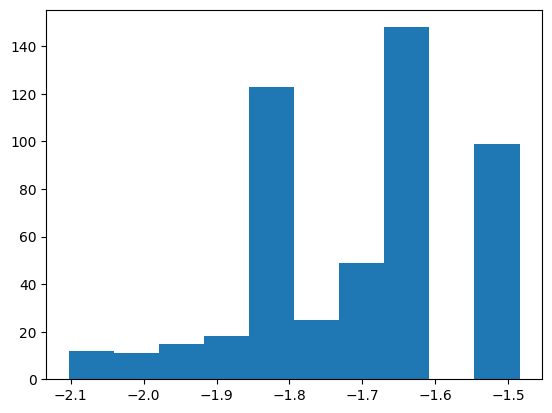

In [ ]:
# likelihood of censored normal on the censored sample
_ = plt.hist(Z.log_prob(z).numpy()), Z.log_prob(z).numpy().mean()

In [ ]:
# likelihood of censored normal on the uncensored sample --> expected behaviour
_ = plt.hist(Z.log_prob(y).numpy()), Z.log_prob(y).numpy().mean()

ValueError: Expected value argument (Tensor of shape (500, 1)) to be within the support (Interval(lower_bound=tensor([-0.5000]), upper_bound=tensor([3.]))) of the distribution CensoredNormal(loc: tensor([1.]), scale: tensor([2.]), low: tensor([-0.5000]), high: tensor([3.])), but found invalid values:
tensor([[ 1.5991e+00],
        [ 1.4848e+00],
        [ 1.5664e+00],
        [ 5.3412e-01],
        [ 2.3423e+00],
        [ 2.5635e+00],
        [-2.5806e+00],
        [-2.4968e+00],
        [ 1.3470e+00],
        [ 1.5337e+00],
        [ 1.8570e+00],
        [ 1.4637e+00],
        [-1.0429e+00],
        [-6.5453e-01],
        [ 4.4684e+00],
        [-1.9841e+00],
        [ 1.8424e+00],
        [ 4.0091e+00],
        [ 3.5432e+00],
        [ 2.2373e+00],
        [ 9.2559e-01],
        [ 3.0705e+00],
        [ 9.7983e-01],
        [ 1.1790e+00],
        [ 1.1681e+00],
        [ 1.7800e+00],
        [-1.5968e-01],
        [ 2.7518e+00],
        [ 1.7848e+00],
        [ 3.2169e+00],
        [ 2.7303e+00],
        [ 2.7104e+00],
        [ 2.3102e+00],
        [ 2.2570e+00],
        [-1.4811e+00],
        [ 3.5860e-01],
        [ 4.8624e+00],
        [ 1.2906e+00],
        [-2.8531e-01],
        [ 2.7272e+00],
        [ 4.2615e-01],
        [ 2.2152e+00],
        [ 2.2117e+00],
        [ 3.6219e+00],
        [ 5.4657e-01],
        [ 5.7596e-01],
        [ 2.1436e+00],
        [ 2.2434e+00],
        [ 1.3210e+00],
        [-8.4300e-01],
        [-1.2163e+00],
        [ 6.2524e-01],
        [ 1.8857e+00],
        [ 5.3578e-01],
        [ 9.3470e-01],
        [-3.8945e+00],
        [ 3.9309e+00],
        [ 2.8922e+00],
        [-1.2299e+00],
        [ 3.2292e+00],
        [ 1.0618e+00],
        [-1.6915e+00],
        [ 3.3510e+00],
        [-4.2656e+00],
        [ 3.1946e-01],
        [ 2.9814e+00],
        [-7.0450e-01],
        [ 5.2828e+00],
        [-1.7943e+00],
        [ 3.0665e-01],
        [ 2.6544e+00],
        [-6.2894e-01],
        [ 2.7410e+00],
        [ 1.8575e+00],
        [-1.1646e+00],
        [ 1.1796e+00],
        [-1.4023e-01],
        [ 1.2406e-01],
        [ 2.9446e+00],
        [ 6.0323e+00],
        [ 3.8350e+00],
        [ 2.9788e+00],
        [ 3.7206e+00],
        [ 8.1294e-01],
        [ 4.5925e+00],
        [-4.4436e+00],
        [ 2.3586e+00],
        [ 1.4362e-01],
        [ 1.2088e+00],
        [ 2.3660e+00],
        [-3.0108e-01],
        [-1.9650e-01],
        [ 3.2099e+00],
        [ 1.1468e+00],
        [ 4.6992e-01],
        [ 4.0635e+00],
        [ 1.5307e-01],
        [-1.5865e+00],
        [ 3.2381e-01],
        [-2.4666e+00],
        [-6.8387e-01],
        [-7.9277e-02],
        [-2.0464e+00],
        [ 2.0631e+00],
        [-1.4069e+00],
        [ 1.5085e-01],
        [ 1.1546e+00],
        [ 4.7509e+00],
        [ 9.3067e-02],
        [-5.8513e-01],
        [ 2.9071e+00],
        [ 3.3038e+00],
        [ 7.3369e-01],
        [ 1.1688e+00],
        [ 8.1798e-01],
        [-1.5211e+00],
        [ 2.6884e+00],
        [ 8.1425e-01],
        [-3.9713e-01],
        [ 1.4281e+00],
        [ 6.8840e-01],
        [ 1.4687e+00],
        [ 2.3645e+00],
        [ 3.1853e+00],
        [-3.1710e+00],
        [ 1.2347e-01],
        [ 5.8956e+00],
        [-1.5735e+00],
        [-4.6627e-01],
        [ 1.0594e+00],
        [ 1.0047e-01],
        [ 2.0251e+00],
        [ 2.9272e+00],
        [-2.5631e-01],
        [ 4.6341e-01],
        [ 2.4203e+00],
        [ 1.1554e+00],
        [ 7.1596e-01],
        [-2.8459e+00],
        [ 4.9623e+00],
        [ 2.2584e+00],
        [-7.3248e-01],
        [ 1.6092e+00],
        [ 5.2603e+00],
        [ 9.3772e-01],
        [-1.0221e+00],
        [-5.0940e-01],
        [ 6.9905e-01],
        [-1.0686e+00],
        [ 1.8638e+00],
        [ 5.6349e-01],
        [-1.1188e+00],
        [-8.6639e-01],
        [ 2.4837e+00],
        [-2.8320e-01],
        [-1.2899e+00],
        [ 5.5666e-01],
        [-1.8414e+00],
        [ 4.6060e-02],
        [ 2.8192e+00],
        [-4.0778e-01],
        [ 4.0429e+00],
        [-3.0147e-01],
        [ 2.5502e+00],
        [ 1.4599e+00],
        [ 3.0268e+00],
        [-9.6457e-01],
        [ 5.8500e+00],
        [ 9.3369e-01],
        [ 5.1198e+00],
        [-8.3515e-01],
        [ 7.2313e-01],
        [-3.4005e+00],
        [-1.3475e+00],
        [ 5.6283e+00],
        [ 4.6387e+00],
        [ 9.4786e-01],
        [ 6.8373e-01],
        [ 1.8284e-03],
        [ 3.7225e+00],
        [ 6.2065e-01],
        [ 2.2290e-01],
        [-5.7291e-01],
        [-2.5385e+00],
        [ 1.5726e+00],
        [ 5.7967e-01],
        [-8.4476e-01],
        [ 1.9086e+00],
        [-1.3375e+00],
        [ 2.8440e+00],
        [-2.0614e+00],
        [ 1.0474e+00],
        [ 1.4981e+00],
        [-1.1918e-01],
        [ 2.7913e+00],
        [ 1.0876e+00],
        [ 4.2919e+00],
        [ 1.8333e+00],
        [ 2.3036e+00],
        [ 1.7626e+00],
        [ 5.3700e-01],
        [ 3.4321e+00],
        [ 1.1761e+00],
        [ 2.2616e+00],
        [ 3.0132e-01],
        [-3.9777e-01],
        [-2.0802e+00],
        [-2.7652e-02],
        [-6.6534e-01],
        [ 1.7111e+00],
        [-2.4361e+00],
        [ 1.0263e+00],
        [ 1.3578e+00],
        [ 2.3508e+00],
        [ 2.4189e+00],
        [ 4.6283e+00],
        [ 1.9349e+00],
        [-6.6038e-01],
        [ 2.1600e+00],
        [ 1.1013e+00],
        [-3.5107e-01],
        [-3.4105e-02],
        [-1.0621e+00],
        [ 3.0534e+00],
        [-7.4776e-02],
        [-3.6986e-01],
        [ 3.0132e+00],
        [ 3.6618e-01],
        [ 5.3615e+00],
        [ 1.7909e+00],
        [ 4.0933e+00],
        [ 6.5406e-01],
        [ 1.0057e+00],
        [-1.7410e+00],
        [-1.5085e+00],
        [ 6.4143e-01],
        [ 1.6011e+00],
        [-1.4823e+00],
        [-5.2095e-01],
        [-9.9430e-01],
        [ 3.0192e-01],
        [ 3.8053e+00],
        [ 3.8123e+00],
        [ 6.4179e-01],
        [ 3.0255e+00],
        [ 2.2408e+00],
        [ 4.2636e+00],
        [-4.9658e-01],
        [ 1.0276e+00],
        [ 3.4260e-01],
        [ 1.5611e+00],
        [ 2.3684e-01],
        [ 3.1010e+00],
        [ 1.4580e+00],
        [ 4.1095e+00],
        [ 3.7636e+00],
        [ 1.9561e+00],
        [ 2.8682e+00],
        [-1.2987e+00],
        [ 8.5610e-01],
        [ 1.1883e+00],
        [ 5.3928e-01],
        [-2.7996e+00],
        [ 2.8957e+00],
        [-1.5499e-01],
        [ 2.2546e+00],
        [ 1.1702e+00],
        [ 6.5321e-01],
        [ 3.4672e+00],
        [ 3.7835e+00],
        [-8.3635e-01],
        [ 2.6135e+00],
        [ 5.9372e-01],
        [ 1.3904e+00],
        [ 1.4983e+00],
        [ 6.7795e-02],
        [-8.0580e-01],
        [ 1.9888e-01],
        [-1.7028e+00],
        [-8.0360e-01],
        [-2.3749e+00],
        [ 2.7011e+00],
        [ 2.3545e+00],
        [ 1.1476e+00],
        [ 4.9841e+00],
        [ 3.3910e-01],
        [ 2.1936e-01],
        [ 3.9974e+00],
        [ 4.5955e+00],
        [ 1.4637e+00],
        [ 4.4300e-02],
        [ 1.5989e+00],
        [ 2.6978e+00],
        [ 1.6630e+00],
        [ 1.2578e+00],
        [-1.4476e+00],
        [-2.4865e-01],
        [ 1.0042e+00],
        [-1.0207e+00],
        [-1.2392e+00],
        [-1.5265e+00],
        [ 3.9052e+00],
        [ 2.3859e+00],
        [ 1.6870e+00],
        [ 1.4655e+00],
        [-1.5093e+00],
        [ 2.6775e+00],
        [-2.7081e-01],
        [-1.4347e+00],
        [ 3.4629e+00],
        [ 7.5559e-01],
        [-2.0133e+00],
        [ 7.3766e-01],
        [ 9.3753e-01],
        [ 2.0250e+00],
        [ 2.6348e+00],
        [ 4.4550e-01],
        [-6.3412e-01],
        [ 1.2208e+00],
        [ 1.0482e+00],
        [-9.9083e-01],
        [-4.0511e-01],
        [ 1.8220e+00],
        [ 2.5478e+00],
        [-1.5525e+00],
        [ 7.1319e-01],
        [ 1.3981e+00],
        [-2.0801e+00],
        [ 4.0966e+00],
        [ 2.8577e+00],
        [ 1.1678e+00],
        [ 1.7146e+00],
        [ 1.3572e+00],
        [-3.5378e-01],
        [ 2.7009e+00],
        [ 2.8851e+00],
        [ 4.7095e+00],
        [ 9.3961e-01],
        [ 5.4876e-01],
        [ 1.3874e+00],
        [ 2.0117e+00],
        [ 1.2077e+00],
        [-1.8153e+00],
        [ 3.0599e+00],
        [ 5.3547e+00],
        [ 1.8731e+00],
        [ 1.5693e-01],
        [-8.6412e-01],
        [ 4.6221e+00],
        [-1.9716e+00],
        [ 2.4779e+00],
        [ 2.3289e+00],
        [ 1.1880e+00],
        [-1.9343e+00],
        [-1.4395e+00],
        [-1.6548e+00],
        [ 2.2200e+00],
        [ 7.7971e-01],
        [-1.6587e+00],
        [ 2.4204e+00],
        [ 9.6658e-01],
        [ 1.8669e+00],
        [ 9.7076e-01],
        [ 2.3912e+00],
        [ 2.1445e+00],
        [-1.9634e+00],
        [ 6.9353e-01],
        [ 3.1806e+00],
        [-8.8601e-01],
        [ 6.5320e-01],
        [ 2.9607e+00],
        [ 1.1256e+00],
        [ 3.0847e+00],
        [ 4.1090e+00],
        [ 4.1699e+00],
        [ 2.4399e+00],
        [ 6.2762e+00],
        [ 4.4639e-01],
        [ 1.3926e+00],
        [ 2.7463e+00],
        [ 1.0204e+00],
        [-7.6768e-01],
        [ 2.6137e+00],
        [ 1.5985e+00],
        [ 2.6478e+00],
        [ 3.0405e+00],
        [ 3.6693e+00],
        [ 1.7277e+00],
        [ 2.5224e+00],
        [-7.6584e-01],
        [ 1.5383e+00],
        [ 8.0801e-01],
        [-3.1094e-01],
        [ 2.3632e+00],
        [ 4.1475e-01],
        [ 2.8725e+00],
        [ 1.2836e+00],
        [ 3.2606e-02],
        [-1.4858e+00],
        [ 1.5460e+00],
        [ 1.2300e+00],
        [ 3.0316e+00],
        [ 4.2259e+00],
        [ 6.1650e-01],
        [ 2.2329e+00],
        [ 5.8859e-01],
        [ 1.8431e+00],
        [-1.4151e-01],
        [ 2.3073e+00],
        [ 4.1135e-01],
        [ 4.7792e-02],
        [-1.6242e+00],
        [-8.5284e-01],
        [ 1.2958e+00],
        [ 1.0139e+00],
        [ 1.6612e+00],
        [ 2.7091e+00],
        [ 1.3508e-01],
        [ 9.5101e-01],
        [ 4.9620e+00],
        [ 4.6826e-01],
        [ 1.0222e+00],
        [ 3.0222e+00],
        [-1.3332e+00],
        [-5.9836e-01],
        [ 1.3732e+00],
        [ 2.7485e+00],
        [ 1.4543e+00],
        [-2.6647e-02],
        [-8.9584e-02],
        [-1.8982e+00],
        [-1.6611e-01],
        [ 9.8562e-01],
        [ 4.0770e-01],
        [-5.1834e-01],
        [ 3.3619e+00],
        [ 7.0663e-01],
        [ 2.1893e+00],
        [ 4.9426e-02],
        [ 3.3677e+00],
        [ 3.1840e-02],
        [ 3.0335e-01],
        [ 9.3715e-01],
        [ 2.2054e+00],
        [ 7.4618e-01],
        [ 7.3484e-01],
        [ 2.7244e+00],
        [-3.3050e-01],
        [ 9.6254e-01],
        [ 1.1128e+00],
        [ 2.1577e-02],
        [-4.6120e-01],
        [-2.5490e-01],
        [-2.0411e-01],
        [ 3.6262e+00],
        [ 7.1222e-01],
        [ 3.6328e+00],
        [ 7.4812e-01],
        [ 3.5122e+00],
        [ 3.3317e+00],
        [-2.4019e+00],
        [ 3.1127e-01],
        [-9.1053e-01],
        [-3.2474e+00],
        [-9.0679e-01],
        [ 4.0220e+00],
        [ 8.7592e-01],
        [-2.5284e+00],
        [ 3.9970e+00],
        [ 1.8413e-01],
        [ 3.8595e+00],
        [ 4.2051e-01],
        [ 2.5472e+00],
        [ 2.2208e+00],
        [-8.4406e-02],
        [-1.2985e+00],
        [ 4.4151e+00],
        [ 3.9058e+00],
        [ 4.1071e+00],
        [ 2.6291e+00],
        [ 7.5669e-01],
        [ 7.2830e-01],
        [ 2.7041e+00],
        [ 2.4490e+00],
        [ 2.3931e+00],
        [ 3.2799e-01],
        [ 3.2811e-01],
        [-1.6908e+00],
        [ 1.2471e+00],
        [ 8.2062e-01],
        [-1.0493e+00],
        [ 3.5496e+00],
        [ 4.5332e+00],
        [ 5.5066e+00],
        [ 5.3637e+00],
        [-9.9477e-02],
        [ 2.7709e+00],
        [ 4.6124e-01],
        [-6.4898e-01],
        [ 9.9308e-01]])

In [ ]:
# likelihood of normal on the uncensored sample: behaviour of HalfNormal as implemented in Pytorch
_ = plt.hist(W.log_prob(y).numpy()), W.log_prob(y).numpy().mean()

ValueError: Expected value argument (Tensor of shape (500, 1)) to be within the support (GreaterThanEq(lower_bound=0.0)) of the distribution HalfNormal(), but found invalid values:
tensor([[ 1.5991e+00],
        [ 1.4848e+00],
        [ 1.5664e+00],
        [ 5.3412e-01],
        [ 2.3423e+00],
        [ 2.5635e+00],
        [-2.5806e+00],
        [-2.4968e+00],
        [ 1.3470e+00],
        [ 1.5337e+00],
        [ 1.8570e+00],
        [ 1.4637e+00],
        [-1.0429e+00],
        [-6.5453e-01],
        [ 4.4684e+00],
        [-1.9841e+00],
        [ 1.8424e+00],
        [ 4.0091e+00],
        [ 3.5432e+00],
        [ 2.2373e+00],
        [ 9.2559e-01],
        [ 3.0705e+00],
        [ 9.7983e-01],
        [ 1.1790e+00],
        [ 1.1681e+00],
        [ 1.7800e+00],
        [-1.5968e-01],
        [ 2.7518e+00],
        [ 1.7848e+00],
        [ 3.2169e+00],
        [ 2.7303e+00],
        [ 2.7104e+00],
        [ 2.3102e+00],
        [ 2.2570e+00],
        [-1.4811e+00],
        [ 3.5860e-01],
        [ 4.8624e+00],
        [ 1.2906e+00],
        [-2.8531e-01],
        [ 2.7272e+00],
        [ 4.2615e-01],
        [ 2.2152e+00],
        [ 2.2117e+00],
        [ 3.6219e+00],
        [ 5.4657e-01],
        [ 5.7596e-01],
        [ 2.1436e+00],
        [ 2.2434e+00],
        [ 1.3210e+00],
        [-8.4300e-01],
        [-1.2163e+00],
        [ 6.2524e-01],
        [ 1.8857e+00],
        [ 5.3578e-01],
        [ 9.3470e-01],
        [-3.8945e+00],
        [ 3.9309e+00],
        [ 2.8922e+00],
        [-1.2299e+00],
        [ 3.2292e+00],
        [ 1.0618e+00],
        [-1.6915e+00],
        [ 3.3510e+00],
        [-4.2656e+00],
        [ 3.1946e-01],
        [ 2.9814e+00],
        [-7.0450e-01],
        [ 5.2828e+00],
        [-1.7943e+00],
        [ 3.0665e-01],
        [ 2.6544e+00],
        [-6.2894e-01],
        [ 2.7410e+00],
        [ 1.8575e+00],
        [-1.1646e+00],
        [ 1.1796e+00],
        [-1.4023e-01],
        [ 1.2406e-01],
        [ 2.9446e+00],
        [ 6.0323e+00],
        [ 3.8350e+00],
        [ 2.9788e+00],
        [ 3.7206e+00],
        [ 8.1294e-01],
        [ 4.5925e+00],
        [-4.4436e+00],
        [ 2.3586e+00],
        [ 1.4362e-01],
        [ 1.2088e+00],
        [ 2.3660e+00],
        [-3.0108e-01],
        [-1.9650e-01],
        [ 3.2099e+00],
        [ 1.1468e+00],
        [ 4.6992e-01],
        [ 4.0635e+00],
        [ 1.5307e-01],
        [-1.5865e+00],
        [ 3.2381e-01],
        [-2.4666e+00],
        [-6.8387e-01],
        [-7.9277e-02],
        [-2.0464e+00],
        [ 2.0631e+00],
        [-1.4069e+00],
        [ 1.5085e-01],
        [ 1.1546e+00],
        [ 4.7509e+00],
        [ 9.3067e-02],
        [-5.8513e-01],
        [ 2.9071e+00],
        [ 3.3038e+00],
        [ 7.3369e-01],
        [ 1.1688e+00],
        [ 8.1798e-01],
        [-1.5211e+00],
        [ 2.6884e+00],
        [ 8.1425e-01],
        [-3.9713e-01],
        [ 1.4281e+00],
        [ 6.8840e-01],
        [ 1.4687e+00],
        [ 2.3645e+00],
        [ 3.1853e+00],
        [-3.1710e+00],
        [ 1.2347e-01],
        [ 5.8956e+00],
        [-1.5735e+00],
        [-4.6627e-01],
        [ 1.0594e+00],
        [ 1.0047e-01],
        [ 2.0251e+00],
        [ 2.9272e+00],
        [-2.5631e-01],
        [ 4.6341e-01],
        [ 2.4203e+00],
        [ 1.1554e+00],
        [ 7.1596e-01],
        [-2.8459e+00],
        [ 4.9623e+00],
        [ 2.2584e+00],
        [-7.3248e-01],
        [ 1.6092e+00],
        [ 5.2603e+00],
        [ 9.3772e-01],
        [-1.0221e+00],
        [-5.0940e-01],
        [ 6.9905e-01],
        [-1.0686e+00],
        [ 1.8638e+00],
        [ 5.6349e-01],
        [-1.1188e+00],
        [-8.6639e-01],
        [ 2.4837e+00],
        [-2.8320e-01],
        [-1.2899e+00],
        [ 5.5666e-01],
        [-1.8414e+00],
        [ 4.6060e-02],
        [ 2.8192e+00],
        [-4.0778e-01],
        [ 4.0429e+00],
        [-3.0147e-01],
        [ 2.5502e+00],
        [ 1.4599e+00],
        [ 3.0268e+00],
        [-9.6457e-01],
        [ 5.8500e+00],
        [ 9.3369e-01],
        [ 5.1198e+00],
        [-8.3515e-01],
        [ 7.2313e-01],
        [-3.4005e+00],
        [-1.3475e+00],
        [ 5.6283e+00],
        [ 4.6387e+00],
        [ 9.4786e-01],
        [ 6.8373e-01],
        [ 1.8284e-03],
        [ 3.7225e+00],
        [ 6.2065e-01],
        [ 2.2290e-01],
        [-5.7291e-01],
        [-2.5385e+00],
        [ 1.5726e+00],
        [ 5.7967e-01],
        [-8.4476e-01],
        [ 1.9086e+00],
        [-1.3375e+00],
        [ 2.8440e+00],
        [-2.0614e+00],
        [ 1.0474e+00],
        [ 1.4981e+00],
        [-1.1918e-01],
        [ 2.7913e+00],
        [ 1.0876e+00],
        [ 4.2919e+00],
        [ 1.8333e+00],
        [ 2.3036e+00],
        [ 1.7626e+00],
        [ 5.3700e-01],
        [ 3.4321e+00],
        [ 1.1761e+00],
        [ 2.2616e+00],
        [ 3.0132e-01],
        [-3.9777e-01],
        [-2.0802e+00],
        [-2.7652e-02],
        [-6.6534e-01],
        [ 1.7111e+00],
        [-2.4361e+00],
        [ 1.0263e+00],
        [ 1.3578e+00],
        [ 2.3508e+00],
        [ 2.4189e+00],
        [ 4.6283e+00],
        [ 1.9349e+00],
        [-6.6038e-01],
        [ 2.1600e+00],
        [ 1.1013e+00],
        [-3.5107e-01],
        [-3.4105e-02],
        [-1.0621e+00],
        [ 3.0534e+00],
        [-7.4776e-02],
        [-3.6986e-01],
        [ 3.0132e+00],
        [ 3.6618e-01],
        [ 5.3615e+00],
        [ 1.7909e+00],
        [ 4.0933e+00],
        [ 6.5406e-01],
        [ 1.0057e+00],
        [-1.7410e+00],
        [-1.5085e+00],
        [ 6.4143e-01],
        [ 1.6011e+00],
        [-1.4823e+00],
        [-5.2095e-01],
        [-9.9430e-01],
        [ 3.0192e-01],
        [ 3.8053e+00],
        [ 3.8123e+00],
        [ 6.4179e-01],
        [ 3.0255e+00],
        [ 2.2408e+00],
        [ 4.2636e+00],
        [-4.9658e-01],
        [ 1.0276e+00],
        [ 3.4260e-01],
        [ 1.5611e+00],
        [ 2.3684e-01],
        [ 3.1010e+00],
        [ 1.4580e+00],
        [ 4.1095e+00],
        [ 3.7636e+00],
        [ 1.9561e+00],
        [ 2.8682e+00],
        [-1.2987e+00],
        [ 8.5610e-01],
        [ 1.1883e+00],
        [ 5.3928e-01],
        [-2.7996e+00],
        [ 2.8957e+00],
        [-1.5499e-01],
        [ 2.2546e+00],
        [ 1.1702e+00],
        [ 6.5321e-01],
        [ 3.4672e+00],
        [ 3.7835e+00],
        [-8.3635e-01],
        [ 2.6135e+00],
        [ 5.9372e-01],
        [ 1.3904e+00],
        [ 1.4983e+00],
        [ 6.7795e-02],
        [-8.0580e-01],
        [ 1.9888e-01],
        [-1.7028e+00],
        [-8.0360e-01],
        [-2.3749e+00],
        [ 2.7011e+00],
        [ 2.3545e+00],
        [ 1.1476e+00],
        [ 4.9841e+00],
        [ 3.3910e-01],
        [ 2.1936e-01],
        [ 3.9974e+00],
        [ 4.5955e+00],
        [ 1.4637e+00],
        [ 4.4300e-02],
        [ 1.5989e+00],
        [ 2.6978e+00],
        [ 1.6630e+00],
        [ 1.2578e+00],
        [-1.4476e+00],
        [-2.4865e-01],
        [ 1.0042e+00],
        [-1.0207e+00],
        [-1.2392e+00],
        [-1.5265e+00],
        [ 3.9052e+00],
        [ 2.3859e+00],
        [ 1.6870e+00],
        [ 1.4655e+00],
        [-1.5093e+00],
        [ 2.6775e+00],
        [-2.7081e-01],
        [-1.4347e+00],
        [ 3.4629e+00],
        [ 7.5559e-01],
        [-2.0133e+00],
        [ 7.3766e-01],
        [ 9.3753e-01],
        [ 2.0250e+00],
        [ 2.6348e+00],
        [ 4.4550e-01],
        [-6.3412e-01],
        [ 1.2208e+00],
        [ 1.0482e+00],
        [-9.9083e-01],
        [-4.0511e-01],
        [ 1.8220e+00],
        [ 2.5478e+00],
        [-1.5525e+00],
        [ 7.1319e-01],
        [ 1.3981e+00],
        [-2.0801e+00],
        [ 4.0966e+00],
        [ 2.8577e+00],
        [ 1.1678e+00],
        [ 1.7146e+00],
        [ 1.3572e+00],
        [-3.5378e-01],
        [ 2.7009e+00],
        [ 2.8851e+00],
        [ 4.7095e+00],
        [ 9.3961e-01],
        [ 5.4876e-01],
        [ 1.3874e+00],
        [ 2.0117e+00],
        [ 1.2077e+00],
        [-1.8153e+00],
        [ 3.0599e+00],
        [ 5.3547e+00],
        [ 1.8731e+00],
        [ 1.5693e-01],
        [-8.6412e-01],
        [ 4.6221e+00],
        [-1.9716e+00],
        [ 2.4779e+00],
        [ 2.3289e+00],
        [ 1.1880e+00],
        [-1.9343e+00],
        [-1.4395e+00],
        [-1.6548e+00],
        [ 2.2200e+00],
        [ 7.7971e-01],
        [-1.6587e+00],
        [ 2.4204e+00],
        [ 9.6658e-01],
        [ 1.8669e+00],
        [ 9.7076e-01],
        [ 2.3912e+00],
        [ 2.1445e+00],
        [-1.9634e+00],
        [ 6.9353e-01],
        [ 3.1806e+00],
        [-8.8601e-01],
        [ 6.5320e-01],
        [ 2.9607e+00],
        [ 1.1256e+00],
        [ 3.0847e+00],
        [ 4.1090e+00],
        [ 4.1699e+00],
        [ 2.4399e+00],
        [ 6.2762e+00],
        [ 4.4639e-01],
        [ 1.3926e+00],
        [ 2.7463e+00],
        [ 1.0204e+00],
        [-7.6768e-01],
        [ 2.6137e+00],
        [ 1.5985e+00],
        [ 2.6478e+00],
        [ 3.0405e+00],
        [ 3.6693e+00],
        [ 1.7277e+00],
        [ 2.5224e+00],
        [-7.6584e-01],
        [ 1.5383e+00],
        [ 8.0801e-01],
        [-3.1094e-01],
        [ 2.3632e+00],
        [ 4.1475e-01],
        [ 2.8725e+00],
        [ 1.2836e+00],
        [ 3.2606e-02],
        [-1.4858e+00],
        [ 1.5460e+00],
        [ 1.2300e+00],
        [ 3.0316e+00],
        [ 4.2259e+00],
        [ 6.1650e-01],
        [ 2.2329e+00],
        [ 5.8859e-01],
        [ 1.8431e+00],
        [-1.4151e-01],
        [ 2.3073e+00],
        [ 4.1135e-01],
        [ 4.7792e-02],
        [-1.6242e+00],
        [-8.5284e-01],
        [ 1.2958e+00],
        [ 1.0139e+00],
        [ 1.6612e+00],
        [ 2.7091e+00],
        [ 1.3508e-01],
        [ 9.5101e-01],
        [ 4.9620e+00],
        [ 4.6826e-01],
        [ 1.0222e+00],
        [ 3.0222e+00],
        [-1.3332e+00],
        [-5.9836e-01],
        [ 1.3732e+00],
        [ 2.7485e+00],
        [ 1.4543e+00],
        [-2.6647e-02],
        [-8.9584e-02],
        [-1.8982e+00],
        [-1.6611e-01],
        [ 9.8562e-01],
        [ 4.0770e-01],
        [-5.1834e-01],
        [ 3.3619e+00],
        [ 7.0663e-01],
        [ 2.1893e+00],
        [ 4.9426e-02],
        [ 3.3677e+00],
        [ 3.1840e-02],
        [ 3.0335e-01],
        [ 9.3715e-01],
        [ 2.2054e+00],
        [ 7.4618e-01],
        [ 7.3484e-01],
        [ 2.7244e+00],
        [-3.3050e-01],
        [ 9.6254e-01],
        [ 1.1128e+00],
        [ 2.1577e-02],
        [-4.6120e-01],
        [-2.5490e-01],
        [-2.0411e-01],
        [ 3.6262e+00],
        [ 7.1222e-01],
        [ 3.6328e+00],
        [ 7.4812e-01],
        [ 3.5122e+00],
        [ 3.3317e+00],
        [-2.4019e+00],
        [ 3.1127e-01],
        [-9.1053e-01],
        [-3.2474e+00],
        [-9.0679e-01],
        [ 4.0220e+00],
        [ 8.7592e-01],
        [-2.5284e+00],
        [ 3.9970e+00],
        [ 1.8413e-01],
        [ 3.8595e+00],
        [ 4.2051e-01],
        [ 2.5472e+00],
        [ 2.2208e+00],
        [-8.4406e-02],
        [-1.2985e+00],
        [ 4.4151e+00],
        [ 3.9058e+00],
        [ 4.1071e+00],
        [ 2.6291e+00],
        [ 7.5669e-01],
        [ 7.2830e-01],
        [ 2.7041e+00],
        [ 2.4490e+00],
        [ 2.3931e+00],
        [ 3.2799e-01],
        [ 3.2811e-01],
        [-1.6908e+00],
        [ 1.2471e+00],
        [ 8.2062e-01],
        [-1.0493e+00],
        [ 3.5496e+00],
        [ 4.5332e+00],
        [ 5.5066e+00],
        [ 5.3637e+00],
        [-9.9477e-02],
        [ 2.7709e+00],
        [ 4.6124e-01],
        [-6.4898e-01],
        [ 9.9308e-01]])

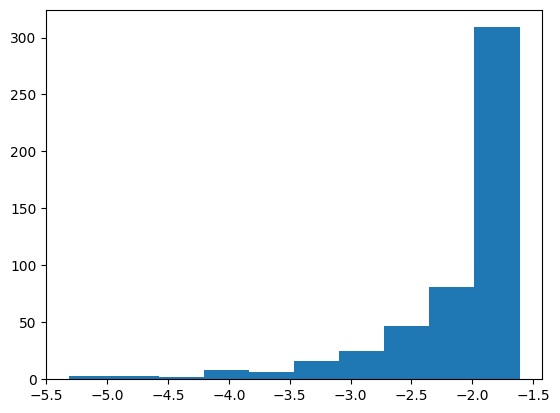

In [ ]:
# likelihood of normal on the uncensored sample
_ = plt.hist(Y.log_prob(y).numpy()), Y.log_prob(y).numpy().mean()

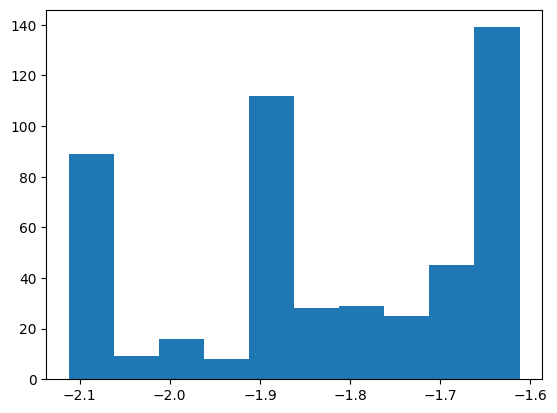

In [ ]:
# likelihood of normal on the censored sample
_ = plt.hist(Y.log_prob(z).numpy()), Y.log_prob(z).numpy().mean()

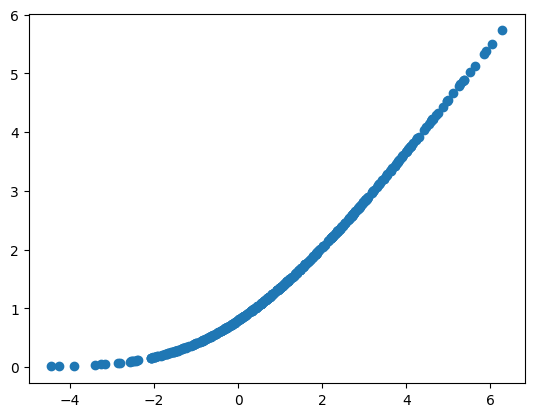

In [ ]:
plt.scatter(y, W.icdf(Y.cdf(y)))

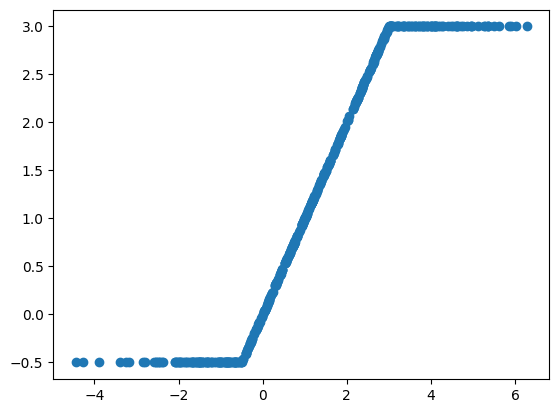

In [ ]:
plt.scatter(y, Z.icdf(Y.cdf(y)))